# MIE 1624 Introduction to Data Science and Analytics – Winter 2018
## Assignment 2: Classification Problem
#### Kexin Zhang

The goal of this assignment is to train, validate, and tune multiple classifiers that can predict, given a set of observations about a person, which income bracket they fall into. Datau used in this assignment is census data from a previous year that contains information about people across the United States.

<b> Note: </b> <br></br>
1. The two csv files used (<i> income-training.csv </i>, <i> income-testing.csv </i>) should be in the same directory as this IPython script.
2. Some sections in this script requries longer computation time, your patience is very much appriciated!

First, import all libraries needed:

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
import random
from string import ascii_letters
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression,PassiveAggressiveClassifier,SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## 1. Data Cleaning

### 1.1 Read data from csv files

In [2]:
raw_train = pd.read_csv('income-training.csv')
raw_test = pd.read_csv('income-testing.csv')

In [3]:
raw_train.head()

,Age,WorkClass,FinalWeight,Education,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket
0,42,State-gov,179151,Some-college,10,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,40,United-States,<50K
1,28,Private,68021,Some-college,10,Never-married,Other-service,Not-in-family,White,Female,0,0,30,United-States,<50K
2,24,Private,233499,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,50-100K
3,32,Self-emp-not-inc,168782,9th,5,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,32,United-States,<50K
4,55,Self-emp-not-inc,105582,Masters,14,Married-civ-spouse,Sales,Husband,White,Male,2228,0,50,United-States,<50K


In [4]:
raw_test.head()

,Age,WorkClass,FinalWeight,Education,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket
0,57,Self-emp-not-inc,152030,Some-college,10,Married-civ-spouse,Sales,Wife,White,Female,0,0,25,United-States,50-100K
1,35,Private,341643,Bachelors,13,Never-married,Other-service,Other-relative,White,Male,0,0,50,United-States,<50K
2,26,Private,40915,Bachelors,13,Never-married,Other-service,Not-in-family,White,Female,0,0,25,United-States,<50K
3,27,Federal-gov,257124,Bachelors,13,Never-married,Transport-moving,Other-relative,White,Male,0,0,35,United-States,<50K
4,21,Private,256278,HS-grad,9,Never-married,Other-service,Other-relative,Other,Female,0,0,35,El-Salvador,<50K


### 1.2 Clean data in dataframe

The function `clean_data` is defined to clean up both training and testing data sets. First, `clean_data` function checks if a feature is an object (an object corresponds to a categorical feature) then change the corresponding column type to category. Empty values are filled with the feature's mode. Then, categorical data is converted into numerical data by encoding using `pandas.Series.cat.codes ` function that maps categorical varaibles to integer values. On the other hand, features that are not objects corresponds to continous features and missing values are replaced with the feature's mean value. <br>
<b>Input: </b><br>
- df: dataframe containing training or testing data <br>
- set_name: can be either 'train' or 'test', depending on which data set is to be cleaned <br>

<b>Output: </b><br>
- cleaned_df: cleaned data in dataframe



In [5]:
def clean_data(df, set_name):
    cleaned_df = df.copy()
    for column in cleaned_df:
        if(cleaned_df[column].dtypes == 'object'):
            cleaned_df[column] = cleaned_df[column].astype('category')
            cleaned_df[column] = cleaned_df[column].fillna(cleaned_df[column].mode()[0])
            cleaned_df[column] = cleaned_df[column].cat.codes
        else:
            if set_name == 'train':
                cleaned_df[column] = cleaned_df[column].fillna(round(raw_train[column].mean()))
            elif set_name == 'test':
                cleaned_df[column] = cleaned_df[column].fillna(round(raw_test[column].mean()))
    
    return cleaned_df

In [6]:
clean_train = clean_data(raw_train,'train')
clean_test = clean_data(raw_test, 'test')

In [7]:
clean_train.head()

,Age,WorkClass,FinalWeight,Education,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket
0,42,6,179151,15,10,2,4,0,4,1,0,0,40,38,1
1,28,3,68021,15,10,4,7,1,4,0,0,0,30,38,1
2,24,3,233499,15,10,2,13,0,4,1,0,0,40,38,0
3,32,5,168782,6,5,2,2,0,4,1,0,0,32,38,1
4,55,5,105582,12,14,2,11,0,4,1,2228,0,50,38,1


In [8]:
clean_test.head()

,Age,WorkClass,FinalWeight,Education,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket
0,57,5,152030,15,10,2,11,5,4,0,0,0,25,37,0
1,35,3,341643,9,13,4,7,2,4,1,0,0,50,37,1
2,26,3,40915,9,13,4,7,1,4,0,0,0,25,37,1
3,27,0,257124,9,13,4,13,2,4,1,0,0,35,37,1
4,21,3,256278,11,9,4,7,2,3,0,0,0,35,7,1


### 1.3 Split training and testing data in to feature and target sets

Since we are interested in IncomeBracket (last column), split the first 14 columns (features) into set x and IncomeBracket into set y (target).

In [9]:
train_x = clean_train[clean_train.columns[0:14]]
train_y = clean_train[clean_train.columns[14]]
test_x = clean_test[clean_train.columns[0:14]]
test_y = clean_test[clean_train.columns[14]]

## 2. Exploratory Data Analysis

This section looks into the income trends relating to four features: Education Level, Work Class, Marital Stauts and Gender. <br>

The function `income_analysis` is defined study the distribution of categorical features in three income groups: <br>
 - high-income (more than 100K) <br>
 - mid-income(50-100K) <br>
 - low-income (less than 50K)   <br>

<b>Input: </b><br>
- level: income level, can be 0(mid), 1(low) or 2(high) <br>
- feature: name of the specific feature of interest (e.g. 'EducationLvl') <br>

<b>Output: </b><br>
- income_feature_freq: list of frequencies of each group in the selected feature <br>

In [10]:
def income_analysis(level, feature):
    income_feature_freq = []
    # Values in EdicationLvl column start from 1 instead of 0
    if feature == 'EducationLvl':
        for category in range(1,max(clean_train[feature])+1):
            count = 0
            for index, row in clean_train.iterrows():
                if row['IncomeBracket'] == level and row[feature] == category:
                    count += 1 

            category += 1
            income_feature_freq.append(count)
    
    else:
        for category in range(0,max(clean_train[feature])+1):
            count = 0
            for index, row in clean_train.iterrows():
                if row['IncomeBracket'] == level and row[feature] == category:
                    count += 1 

            category += 1
            income_feature_freq.append(count)
            
    return income_feature_freq

The function `generate_color` will be used to generate color hex values for visulizations. 

<b>Input: </b><br>
- n: number of colors to be generated <br>

<b>Output: </b><br>
- color_list: list containing hex values of n colors

In [11]:
def generate_color(n):
    color_list = []
    for i in range(0,n):
        r = lambda: random.randint(0,255)
        color_hex = '#%02X%02X%02X' % (r(),r(),r())
        color_list.append(color_hex)
    return color_list

### 2.1 Income vs. Education Level

Get Education Level distribution in high, mid and low income groups:

In [12]:
high_income_Ed = income_analysis(2, 'EducationLvl')
low_income_Ed = income_analysis(1, 'EducationLvl')
mid_income_Ed = income_analysis(0, 'EducationLvl')

Ed_titles = ['Preschool', '1st-4th', '5th-6th', '7th-8th','9th', '10th', '11th', '12th','HS-grad', 'Some-college','Assoc-voc','Assoc-acdm','Bachelors','Masters','Prof-school','Doctorate']

Plot Education Level distribution in three income groups:

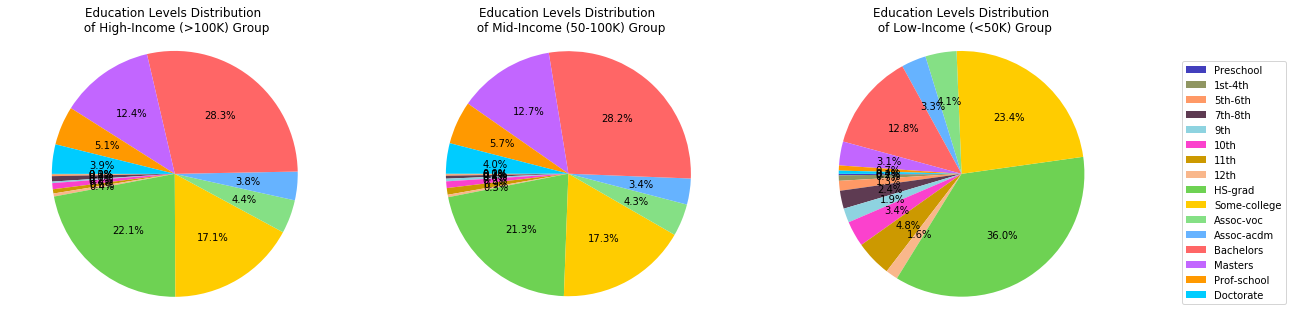

In [13]:
plt.rcParams['figure.figsize'] = (20, 5)

colors_Ed = ['#423FBD','#909662','#ff9966','#5E3B52','#8ED3E0','#FB41CD','#cc9900','#F9B78B','#6ED253','#ffcc00', '#85e085','#66b3ff', '#ff6666','#c266ff', '#ff9900', '#00ccff']
plt.subplot(131)
plt.pie(high_income_Ed, colors = colors_Ed, autopct='%1.1f%%', shadow=False, startangle=180, labeldistance=1.05)
plt.axis('equal')
plt.gca().set_title('Education Levels Distribution \n of High-Income (>100K) Group')

plt.subplot(132)
plt.pie(mid_income_Ed, colors = colors_Ed, autopct='%1.1f%%', shadow=False, startangle=180, labeldistance=1.05)
plt.axis('equal')
plt.gca().set_title('Education Levels Distribution \n of Mid-Income (50-100K) Group')

plt.subplot(133)
plt.pie(low_income_Ed, colors = colors_Ed, autopct='%1.1f%%', shadow=False, startangle=180, labeldistance=1.05)
plt.legend(labels=Ed_titles, loc="lower right", bbox_to_anchor=(1.5,0))
plt.axis('equal')
plt.gca().set_title('Education Levels Distribution \n of Low-Income (<50K) Group') 

plt.show() 

The above results show that in high-income (>100K) group, the education level is more diverse, with most people holding a Bachlors, Masters or HS-degree and others with Doctorate or Prof-school degrees. Low-income group has more people with HS-degree ann college degree. 

### 2.2 Income vs. Work Class

Get Work Class Level distribution in high, mid and low income groups:

In [14]:
high_income_Wclass = income_analysis(2, 'WorkClass')
low_income_Wclass = income_analysis(1, 'WorkClass')
mid_income_Wclass = income_analysis(0, 'WorkClass')

Wclass_titles = ['Federal-gov', 'Local-gov', 'Never-worked', 'Private', 'Self-emp-inc', 'Self-emp-not-inc','State-gov','Without-pay']

Plot Work Class Level distribution in three income groups:

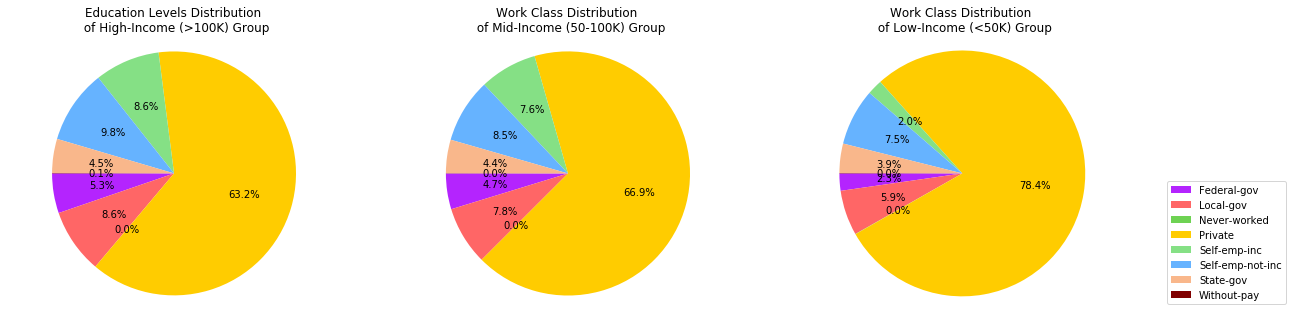

In [15]:
plt.rcParams['figure.figsize'] = (20, 5)

colors_Wclass = ['#B424FE', '#ff6666', '#6ED253','#ffcc00', '#85e085','#66b3ff','#F9B78B', '#800000']
plt.subplot(131)
plt.pie(high_income_Wclass, colors = colors_Wclass, autopct='%1.1f%%', shadow=False, startangle=180, labeldistance=1.05)
plt.axis('equal')
plt.gca().set_title('Education Levels Distribution \n of High-Income (>100K) Group')

plt.subplot(132)
plt.pie(mid_income_Wclass, colors = colors_Wclass, autopct='%1.1f%%', shadow=False, startangle=180, labeldistance=1.05)
plt.axis('equal')
plt.gca().set_title('Work Class Distribution \n of Mid-Income (50-100K) Group')

plt.subplot(133)
plt.pie(low_income_Wclass, colors = colors_Wclass, autopct='%1.1f%%', shadow=False, startangle=180, labeldistance=1.05)
plt.legend(labels=Wclass_titles, loc="lower right", bbox_to_anchor=(1.5,0))
plt.axis('equal')
plt.gca().set_title('Work Class Distribution \n of Low-Income (<50K) Group') 

plt.show() 

The above results show that the majority of people work in private sectors in all three income groups, which suggests that work class doesn't have a strong correlation with income level and the feature can be eliminated during feature selection. 

### 2.3 Income vs. Marital Status

Get Marital Status distribution in high, mid and low income groups:

In [16]:
high_income_Mstatus = income_analysis(2, 'MaritalStatus')
low_income_Mstatus = income_analysis(1, 'MaritalStatus')
mid_income_Mstatus = income_analysis(0, 'MaritalStatus')

Mstatus_titles = ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated','Widowed']

Plot Marital Status distribution in three income groups:

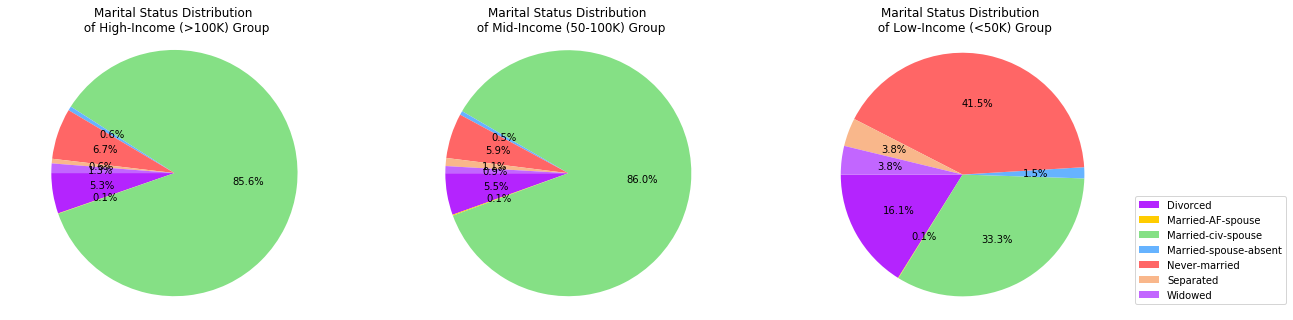

In [17]:
plt.rcParams['figure.figsize'] = (20, 5)

colors_Mstatus = ['#B424FE', '#ffcc00', '#85e085','#66b3ff','#ff6666','#F9B78B','#c266ff']
plt.subplot(131)
plt.pie(high_income_Mstatus, colors = colors_Mstatus, autopct='%1.1f%%', shadow=False, startangle=180, labeldistance=1.05)
plt.axis('equal')
plt.gca().set_title('Marital Status Distribution \n of High-Income (>100K) Group')

plt.subplot(132)
plt.pie(mid_income_Mstatus, colors = colors_Mstatus, autopct='%1.1f%%', shadow=False, startangle=180, labeldistance=1.05)
plt.axis('equal')
plt.gca().set_title('Marital Status Distribution \n of Mid-Income (50-100K) Group')

plt.subplot(133)
plt.pie(low_income_Mstatus, colors = colors_Mstatus, autopct='%1.1f%%', shadow=False, startangle=180, labeldistance=1.05)
plt.legend(labels=Mstatus_titles, loc="lower right", bbox_to_anchor=(1.5,0))
plt.axis('equal')
plt.gca().set_title('Marital Status Distribution \n of Low-Income (<50K) Group') 

plt.show() 

The above results show that for among people with high-income and mid-income, the majority are married with spouse (Married-civ-spouse). In low-income group, a large number of people are also never-married or divorced. The result show some correlation between marital status and correlation. 

### 2.4 Income vs. Gender

Get Gender distribution in high, mid and low income groups:

In [18]:
high_income_gender = income_analysis(2, 'Sex')
low_income_gender = income_analysis(1, 'Sex')
mid_income_gender = income_analysis(0, 'Sex')

gender_titles = ['Female','Male']

Plot Gender distribution in three income groups:

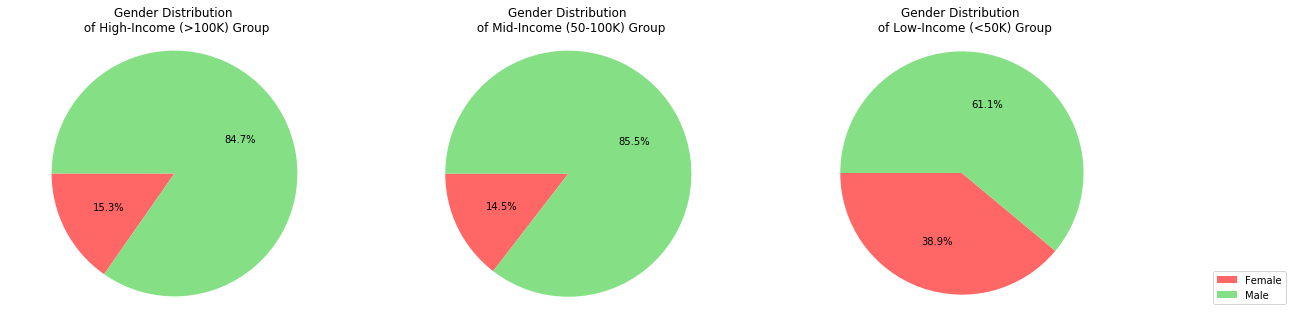

In [19]:
plt.rcParams['figure.figsize'] = (20, 5)

colors_gender = ['#ff6666','#85e085']
plt.subplot(131)
plt.pie(high_income_gender, colors = colors_gender, autopct='%1.1f%%', shadow=False, startangle=180, labeldistance=1.05)
plt.axis('equal')
plt.gca().set_title('Gender Distribution \n of High-Income (>100K) Group')

plt.subplot(132)
plt.pie(mid_income_gender, colors = colors_gender, autopct='%1.1f%%', shadow=False, startangle=180, labeldistance=1.05)
plt.axis('equal')
plt.gca().set_title('Gender Distribution \n of Mid-Income (50-100K) Group')

plt.subplot(133)
plt.pie(low_income_gender, colors = colors_gender, autopct='%1.1f%%', shadow=False, startangle=180, labeldistance=1.05)
plt.legend(labels=gender_titles, loc="lower right", bbox_to_anchor=(1.5,0))
plt.axis('equal')
plt.gca().set_title('Gender Distribution \n of Low-Income (<50K) Group') 

plt.show() 

The above results show that in both high-income and mid-income groups, the majority of people are male and in low-income groups, the percentage of female is higher than the other two income groups. 

### 2.5 Feauture Importance

Plot correlation matrix using seaborn: <br>
reference: https://seaborn.pydata.org/examples/many_pairwise_correlations.html

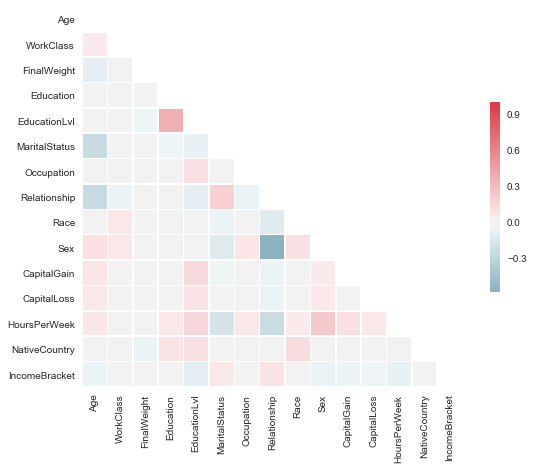

In [20]:
sns.set(style="white")

# Compute the correlation matrix
corr_matrix = clean_train.copy()
corr = corr_matrix.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Plot correlatino matrix with matplotlib:

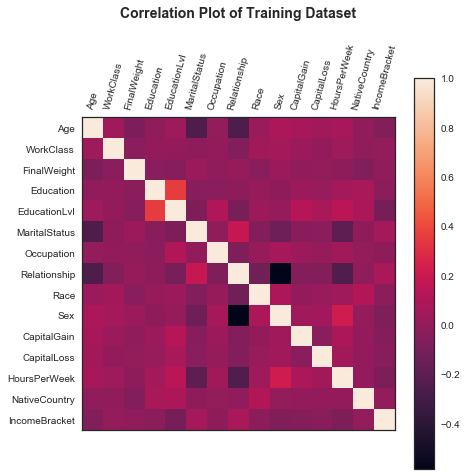

In [21]:
plt.rcParams['figure.figsize'] = (10, 7)

corr_matrix = clean_train.copy()
corr_matrix = corr_matrix.corr()

plt.matshow(np.asarray(corr_matrix))
fea_titles = clean_train.columns[0:15]
cor_y_pos = np.arange(len(fea_titles))

plt.xticks(cor_y_pos, fea_titles, rotation = 75)
plt.yticks(cor_y_pos, fea_titles)
plt.title('Correlation Plot of Training Dataset', fontsize = 14, fontweight = 'bold', y = 1.3)
plt.colorbar()
plt.show()

The following observations can be made based on correlation matrix plot:

- CapitalGaina and CapitalLoss are correalted to IncomeBracket and the two co-correlated features can be integrated into one during feature engineering and selection.
- Marital Status and Relationship features have very strong correlation with each other, but are not strongly correlated with IncomeBracket and therefore these two features can be eliminated during feature selection. 
- HoursPerWeek has strong correlation with IncomeBracket and is to be included during feature selection
- Education and EdcuationLvl are correlated to each other and EducationLvl has more correlation with IncomeBraket. As a result EducationLvl are to be included during feature selection.
- Age and Sex also have strong correlation with IncomeBracket and are to be included during feature selection

## 3. Feature Selection

### 3.1 Feature Engineering

#### 3.1.1 Create Age Bracket

Create age bracket by dividing ages into 5 groups: 0-20(0), 21-30(1), 31-40(2), 41-50(3), 51-100(4). First create a dictionary with keys = continuous ages and values = group numbers (0,1,2,3) that correspond to ages:

In [22]:
age_group = 0
age_mark = 21
age_list = []
age_grouped = []
for i in range(0,100):
    age_list.append(i)
    if i < age_mark:
        age_grouped.append(age_group)
    elif i < 51:
        age_group += 1
        age_mark += 10
        age_grouped.append(age_group)
    else:
        age_grouped.append(4)

In [23]:
age_dict = dict(zip(age_list, age_grouped))

Use `age_dict` to map Age to AgeBracket and add AgeBracket as a new column to the dataframe:

In [24]:
def group_age(df):
    AgeBracket = []
    for index, row in df.iterrows():
        for key, value in age_dict.items():
            if row['Age'] == key:
                AgeBracket.append(value)
    return AgeBracket

In [25]:
clean_train['AgeBracket'] = group_age(clean_train)
clean_test['AgeBracket'] = group_age(clean_test)

In [26]:
clean_train.head()

,Age,WorkClass,FinalWeight,Education,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket,AgeBracket
0,42,6,179151,15,10,2,4,0,4,1,0,0,40,38,1,3
1,28,3,68021,15,10,4,7,1,4,0,0,0,30,38,1,1
2,24,3,233499,15,10,2,13,0,4,1,0,0,40,38,0,1
3,32,5,168782,6,5,2,2,0,4,1,0,0,32,38,1,2
4,55,5,105582,12,14,2,11,0,4,1,2228,0,50,38,1,4


In [27]:
clean_test.head()

,Age,WorkClass,FinalWeight,Education,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket,AgeBracket
0,57,5,152030,15,10,2,11,5,4,0,0,0,25,37,0,4
1,35,3,341643,9,13,4,7,2,4,1,0,0,50,37,1,2
2,26,3,40915,9,13,4,7,1,4,0,0,0,25,37,1,1
3,27,0,257124,9,13,4,13,2,4,1,0,0,35,37,1,1
4,21,3,256278,11,9,4,7,2,3,0,0,0,35,7,1,1


#### 3.1.2 Create Work Hours Bracket

Create work hours bracket by dividing hours per week into 4 groups: 0-30(0), 31-50(1), 51-70(2), 71-100(3). First create a dictionary with keys = continuous hours per week and values = group numbers (0,1,2,3) that correspond to hours per week:

In [28]:
hour_group = 0
hour_mark = 31
hour_list = []
hour_grouped = []
for i in range(0,100):
    hour_list.append(i)
    if i < hour_mark:
        hour_grouped.append(hour_group)
    elif i < 71:
        hour_group += 1
        hour_mark += 20
        hour_grouped.append(hour_group)
    else:
        hour_grouped.append(3)

In [29]:
hours_dict = dict(zip(hour_list, hour_grouped))

Use `hours_dict` to map HoursPerWeek to HoursBracket and add HoursBracket as a new column to the dataframe:

In [30]:
def group_hours(df):
    HoursBracket = []
    for index, row in df.iterrows():
        for key, value in hours_dict.items():
            if row['HoursPerWeek'] == key:
                HoursBracket.append(value)
    return HoursBracket

In [31]:
clean_train['HoursBracket'] = group_hours(clean_train)
clean_test['HoursBracket'] = group_hours(clean_test)

In [32]:
clean_train.head()

,Age,WorkClass,FinalWeight,Education,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket,AgeBracket,HoursBracket
0,42,6,179151,15,10,2,4,0,4,1,0,0,40,38,1,3,1
1,28,3,68021,15,10,4,7,1,4,0,0,0,30,38,1,1,0
2,24,3,233499,15,10,2,13,0,4,1,0,0,40,38,0,1,1
3,32,5,168782,6,5,2,2,0,4,1,0,0,32,38,1,2,1
4,55,5,105582,12,14,2,11,0,4,1,2228,0,50,38,1,4,1


In [33]:
clean_test.head()

,Age,WorkClass,FinalWeight,Education,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket,AgeBracket,HoursBracket
0,57,5,152030,15,10,2,11,5,4,0,0,0,25,37,0,4,0
1,35,3,341643,9,13,4,7,2,4,1,0,0,50,37,1,2,1
2,26,3,40915,9,13,4,7,1,4,0,0,0,25,37,1,1,0
3,27,0,257124,9,13,4,13,2,4,1,0,0,35,37,1,1,1
4,21,3,256278,11,9,4,7,2,3,0,0,0,35,7,1,1,1


#### 3.1.3 Create Investment Class

Combine CapitalGain and CapitalLoss into one feautre - Investiment Class, which contains the following: 
- good investment (2): if the sample has CapitalGain and no (zero) CapitalLoss
- no investment (1): if the sample has neither CapitalGain nor CapitalLoss
- bad investment(0): if the sample has CapitalLoss and no (zero) CapitalGain

In [34]:
def create_investment(df):
    Investment = []
    for index, row in df.iterrows():
            if row['CapitalGain'] != 0 and row['CapitalLoss'] == 0:
                Investment.append(2)
            elif row['CapitalGain'] == 0 and row['CapitalLoss'] != 0:
                Investment.append(0)
            else: 
                Investment.append(1)
    return Investment

In [35]:
clean_train['Investment'] = create_investment(clean_train)
clean_test['Investment'] = create_investment(clean_test)

In [36]:
clean_train.head()

,Age,WorkClass,FinalWeight,Education,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket,AgeBracket,HoursBracket,Investment
0,42,6,179151,15,10,2,4,0,4,1,0,0,40,38,1,3,1,1
1,28,3,68021,15,10,4,7,1,4,0,0,0,30,38,1,1,0,1
2,24,3,233499,15,10,2,13,0,4,1,0,0,40,38,0,1,1,1
3,32,5,168782,6,5,2,2,0,4,1,0,0,32,38,1,2,1,1
4,55,5,105582,12,14,2,11,0,4,1,2228,0,50,38,1,4,1,2


In [37]:
clean_test.head()

,Age,WorkClass,FinalWeight,Education,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket,AgeBracket,HoursBracket,Investment
0,57,5,152030,15,10,2,11,5,4,0,0,0,25,37,0,4,0,1
1,35,3,341643,9,13,4,7,2,4,1,0,0,50,37,1,2,1,1
2,26,3,40915,9,13,4,7,1,4,0,0,0,25,37,1,1,0,1
3,27,0,257124,9,13,4,13,2,4,1,0,0,35,37,1,1,1,1
4,21,3,256278,11,9,4,7,2,3,0,0,0,35,7,1,1,1,1


### 3.2 Feature Selection Result

Based on previous discussions, the important features selected for future analysis are: AgeBracket, EducationLvl, Occupation, Relationship, Sex, Investment and HoursBracket.

In [38]:
new_train = clean_train[['AgeBracket', 'EducationLvl', 'Occupation', 'Relationship', 'Sex', 'Investment', 'HoursBracket', 'IncomeBracket']].copy()
new_test = clean_test[['AgeBracket', 'EducationLvl', 'Occupation', 'Relationship', 'Sex', 'Investment', 'HoursBracket', 'IncomeBracket']].copy()

In [39]:
new_train.head()

,AgeBracket,EducationLvl,Occupation,Relationship,Sex,Investment,HoursBracket,IncomeBracket
0,3,10,4,0,1,1,1,1
1,1,10,7,1,0,1,0,1
2,1,10,13,0,1,1,1,0
3,2,5,2,0,1,1,1,1
4,4,14,11,0,1,2,1,1


In [40]:
new_test.head()

,AgeBracket,EducationLvl,Occupation,Relationship,Sex,Investment,HoursBracket,IncomeBracket
0,4,10,11,5,0,1,0,0
1,2,13,7,2,1,1,1,1
2,1,13,7,1,0,1,0,1
3,1,13,13,2,1,1,1,1
4,1,9,7,2,0,1,1,1


In [41]:
new_train_x = new_train[new_train.columns[0:7]]
new_train_y = new_train[new_train.columns[7]]
new_test_x = new_test[new_test.columns[0:7]]
new_test_y = new_test[new_test.columns[7]]

In [42]:
new_train_x.head()

,AgeBracket,EducationLvl,Occupation,Relationship,Sex,Investment,HoursBracket
0,3,10,4,0,1,1,1
1,1,10,7,1,0,1,0
2,1,10,13,0,1,1,1
3,2,5,2,0,1,1,1
4,4,14,11,0,1,2,1


In [43]:
new_test_x.head()

,AgeBracket,EducationLvl,Occupation,Relationship,Sex,Investment,HoursBracket
0,4,10,11,5,0,1,0
1,2,13,7,2,1,1,1
2,1,13,7,1,0,1,0
3,1,13,13,2,1,1,1
4,1,9,7,2,0,1,1


## 4. Model Implementation

This section uses four different classification methods to model the training data. The four models implemented are: Gradient Boosting (boosting), Random Forest Tree (bagging), Logistic Regression and MultiLayer Perceptron Neural Network Classifier:

- Gradient Boosting is an ensemble method. Like other boosting methods, Gradient Boosting combines weak "learners" into a single strong learner in an iterative fashion. Multiple gradient classifiers are computed where each new classifier is trained on the previously failed sections. The advantage of Gradient Boosting method is that all weak learners work together to come up with a strong solution. Some drawbacks of Gradient Boosting include problems with overshooting.


- Random Forest is also an ensemble method that builds multiple decision trees and merges them together to get a more accurate and stable prediction. Random Forrest algorithm brings extra randomness into the model when it is growing the trees. Instead of searching for the best feature while splitting a node, it searches for the best feature among a random subset of features, which creates a wide diversity and generally results in a better model. A disadvantage of Random Forrest is that it is also associated with overfitting problems.


- Logistic Regression is a classification algorithm used to assign observations to a discrete set of classes. Instead of outputting continuous number values like Linear Regression, Logistic Regression transforms its output using the sigmoid function to return a probability value which can then be mapped to two or more discrete classes. Types of Logistic Regression include Binary (Pass/Fail), Multi (Cats, Dogs, Sheep) and Ordinal (Low, Medium, High)


- Artificial neural networks are crude electronic networks of neurons based on the neural structure of the brain. They process records one at a time and learn by comparing their classification of the record with the known actual classification of the record. The errors from the initial classification of the first record is fed back into the network, and used to modify the networks algorithm for further iterations. The advantage of neural netowrks include he ability to learn and model non-linear and complex relationships while procssing information in a highly parallel way, and disadvantage being that high-diversity of training is required for real-world operation.

Subsequently, 10-fold cross-validation method is used to provide an accurate estimate of out-of-sample accuracy and more efficiency in using data since every observation will be used for both training and testing. 

The general steps of implementing 10-fold cross-validation include:
1. Split the dataset into 10 equal partitions (or "folds").
2. Use fold 1 as the testing set and the union of the other folds as the training set.
3. Calculate testing accuracy.
4. Repeat steps two and three 10 times, using a different fold as the testing set each time.
5. Use the average testing accuracy as the estimate of out-of-sample accuracy.


Prepare training data from data with newly selected features:

In [44]:
x_train = np.asarray(new_train_x).astype('int')
y_train = np.asarray(new_train_y).astype('int')

Create an instance of GradientBoostingClassifier and train the model, then evaluate scores using 10-fold cross validation:

In [45]:
model_GB = GradientBoostingClassifier()
model_GB.fit(x_train, y_train)
cross_val_GB = cross_val_score(model_GB, x_train, y_train, cv = 10, scoring = 'accuracy')
cross_val_GB

array([ 0.79418985,  0.80155483,  0.79664484,  0.79369628,  0.79844326,
        0.79762392,  0.78902089,  0.80458828,  0.79475625,  0.79762392])

Create an instance of RandomForestClassifier and train the model, then evaluate scores using 10-fold cross validation:

In [46]:
model_RF = RandomForestClassifier()
model_RF.fit(x_train, y_train)
cross_val_RF = cross_val_score(model_RF, x_train, y_train, cv = 10, scoring = 'accuracy')
cross_val_RF

array([ 0.76104746,  0.7794599 ,  0.77823241,  0.76668031,  0.77099549,
        0.76485047,  0.77509218,  0.7824662 ,  0.77509218,  0.77263417])

Create an instance of LogisticRegression classifier and train the model, then evaluate scores using 10-fold cross validation:

In [47]:
model_LR = LogisticRegression()
model_LR.fit(x_train, y_train)
cross_val_LR = cross_val_score(model_LR, x_train, y_train, cv = 10, scoring = 'accuracy')
cross_val_LR

array([ 0.77741408,  0.7794599 ,  0.77045827,  0.77322964,  0.77836952,
        0.77795985,  0.77140516,  0.77099549,  0.77795985,  0.77795985])

Create an instance of neural network MLPClassifier and train the model, then evaluate scores using 10-fold cross validation:

In [48]:
model_MLP = MLPClassifier()
model_MLP.fit(x_train, y_train)
cross_val_MLP = cross_val_score(model_MLP, x_train, y_train, cv = 10, scoring = 'accuracy')
cross_val_MLP

array([ 0.78927987,  0.79296236,  0.79255319,  0.78796562,  0.7914789 ,
        0.78943056,  0.79557558,  0.79352724,  0.79188857,  0.79270791])

Calculate and compare average scores of different classification models:

In [49]:
model_name = ['Gradient Boosting', 'Random Forest', 'Logistic Regression', 'Neural Network MLP']
model_avg = [str(round(100*cross_val_GB.mean(),3))+'%', str(round(100*cross_val_RF.mean(),3))+'%', str(round(100*cross_val_LR.mean(),3))+'%', str(round(100*cross_val_MLP.mean(),3))+'%']
model_std = [str(round(100*cross_val_GB.std(),3))+'%', str(round(100*cross_val_RF.std(),3))+'%', str(round(100*cross_val_LR.std(),3))+'%', str(round(100*cross_val_MLP.std(),3))+'%']

model_scores_df = pd.DataFrame({'Classifier': model_name, 'Score Avg': model_avg, 'Standard Deviation': model_std})
model_scores_df

,Classifier,Score Avg,Standard Deviation
0,Gradient Boosting,79.681%,0.41%
1,Random Forest,77.266%,0.648%
2,Logistic Regression,77.552%,0.337%
3,Neural Network MLP,79.174%,0.216%


## 5. Model Tuning

### 5.1 Hyperparameter tuning for Gradiant Boosting Classifier

For GradientBoostingClassifier, the two hyperparameters, `learning_rate` and `n_estimators` are considered: 

<b>learning_rate:</b>
learning_rate determines the impact of each tree on the final outcome. Gradient Boosting operation starts with an initial estimate which is updated using the output of each tree. The learning parameter controls the magnitude of this change in the estimates. Lower learning rate makes the model robust to the specific characteristics of tree and results in better generalization but requires higher number of trees to model all the relations and will be computationally expensive.

<b>n_estimators:</b>
n_estimators represents the number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.

For Gradient Boosting, there is usually a trade-off between the learning_rate and n_estimators.

In [50]:
Lrate_range = np.linspace(0.001, 1, num = 3)
Nestimate_range = np.linspace(10, 100, num = 3).astype('int')

parameters_GB = dict(learning_rate = Lrate_range, n_estimators = Nestimate_range)

grid_GB = GridSearchCV(model_GB, parameters_GB, cv = 3, scoring = 'accuracy')
grid_GB.fit(x_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'learning_rate': array([ 0.001 ,  0.5005,  1.    ]), 'n_estimators': array([ 10,  55, 100])},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [51]:
grid_GB.grid_scores_

[mean: 0.75480, std: 0.00006, params: {'learning_rate': 0.001, 'n_estimators': 10},
 mean: 0.75480, std: 0.00006, params: {'learning_rate': 0.001, 'n_estimators': 55},
 mean: 0.75480, std: 0.00006, params: {'learning_rate': 0.001, 'n_estimators': 100},
 mean: 0.79505, std: 0.00143, params: {'learning_rate': 0.50049999999999994, 'n_estimators': 10},
 mean: 0.79526, std: 0.00074, params: {'learning_rate': 0.50049999999999994, 'n_estimators': 55},
 mean: 0.79399, std: 0.00137, params: {'learning_rate': 0.50049999999999994, 'n_estimators': 100},
 mean: 0.79653, std: 0.00243, params: {'learning_rate': 1.0, 'n_estimators': 10},
 mean: 0.79194, std: 0.00193, params: {'learning_rate': 1.0, 'n_estimators': 55},
 mean: 0.79096, std: 0.00346, params: {'learning_rate': 1.0, 'n_estimators': 100}]

In [52]:
best_GB = pd.DataFrame({'GB Best Parameters': grid_GB.best_params_})
best_GB

,GB Best Parameters
learning_rate,1.0
n_estimators,10.0


In [53]:
print('GB Best Score:', str(round(100*grid_GB.best_score_,3))+'%')

GB Best Score: 79.653%


### 5.2 Hyperparamter tuning for Random Forrest Classifier

For RandomForestClassifier, the hyperparameter, `n_estimators` is considered:

<b>n_estimators:</b> n_estimators represents the number of trees in the foreset. Higher number of trees has better performance but also longer computation time.

<b>max_features:</b> max_features represents the maximum number of features Random Forest is allowed to try in individual tree. Some options include:
- auto : takes all the features which make sense in every tree.
- sqrt : takes square root of the total number of features in individual run.
- 0.2 : takes 20% of variables in individual run.

Increasing max_features generally improves the performance of the model since there is a higher number of options to be considered at each node. However, this decreases the diversity of individual tree. But the speed of algorithm improves by increasing the max_features. Therefore, a tradeoff exists when choosing optimal max_features.

In [54]:
Nestimate_RF_range = np.linspace(10, 3000, num = 4).astype('int')
max_RF_features_types = ['auto','sqrt', 0.2]

parameters_RF = dict(n_estimators = Nestimate_RF_range, max_features = max_RF_features_types)

grid_RF = GridSearchCV(model_RF, parameters_RF, cv = 3, scoring = 'accuracy')
grid_RF.fit(x_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([  10, 1006, 2003, 3000]), 'max_features': ['auto', 'sqrt', 0.2]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [55]:
grid_RF.grid_scores_

[mean: 0.77016, std: 0.00312, params: {'max_features': 'auto', 'n_estimators': 10},
 mean: 0.77511, std: 0.00239, params: {'max_features': 'auto', 'n_estimators': 1006},
 mean: 0.77564, std: 0.00353, params: {'max_features': 'auto', 'n_estimators': 2003},
 mean: 0.77519, std: 0.00260, params: {'max_features': 'auto', 'n_estimators': 3000},
 mean: 0.77069, std: 0.00158, params: {'max_features': 'sqrt', 'n_estimators': 10},
 mean: 0.77609, std: 0.00274, params: {'max_features': 'sqrt', 'n_estimators': 1006},
 mean: 0.77548, std: 0.00280, params: {'max_features': 'sqrt', 'n_estimators': 2003},
 mean: 0.77515, std: 0.00253, params: {'max_features': 'sqrt', 'n_estimators': 3000},
 mean: 0.77053, std: 0.00364, params: {'max_features': 0.2, 'n_estimators': 10},
 mean: 0.77720, std: 0.00333, params: {'max_features': 0.2, 'n_estimators': 1006},
 mean: 0.77630, std: 0.00368, params: {'max_features': 0.2, 'n_estimators': 2003},
 mean: 0.77663, std: 0.00241, params: {'max_features': 0.2, 'n_estima

In [56]:
best_RF = pd.DataFrame({'RF Best Parameters': grid_RF.best_params_, 'RF Best Score': str(round(100*grid_RF.best_score_,3))+'%'})
best_RF

,RF Best Parameters,RF Best Score
max_features,0.2,77.72%
n_estimators,1006.0,77.72%


### 5.3 Hyperparamter tuning for Logistic Regression

For LogisticRegression classifier, the three hyperparameters, solver, multi_class and C are considered:

<b>solver:</b> solver reqpresents the algorithm to use in the optimization problem. For multiclass problems, ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss; ‘newton-cg’, ‘lbfgs’ and ‘sag’ handle L2 penalty, 

<b>multi_class:</b> Multiclass option can be either ‘ovr’ or ‘multinomial’. If the option chosen is ‘ovr’, then a binary problem is fit for each label. Else the loss minimised is the multinomial loss fit across the entire probability distribution.

<b>C:</b> C represents the inverse of regularization strength

In [57]:
C_range = np.linspace(0.1, 1000, num = 3)
solver_opt = ['newton-cg', 'lbfgs', 'sag']
multiClass_opt = ['ovr', 'multinomial']

parameters_LR = dict(solver = solver_opt, multi_class = multiClass_opt, C = C_range)

grid_LR = GridSearchCV(model_LR, parameters_LR, cv = 3, scoring = 'accuracy')
grid_LR.fit(x_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'solver': ['newton-cg', 'lbfgs', 'sag'], 'multi_class': ['ovr', 'multinomial'], 'C': array([  1.00000e-01,   5.00050e+02,   1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [58]:
grid_LR.grid_scores_

[mean: 0.77593, std: 0.00041, params: {'C': 0.10000000000000001, 'multi_class': 'ovr', 'solver': 'newton-cg'},
 mean: 0.77593, std: 0.00041, params: {'C': 0.10000000000000001, 'multi_class': 'ovr', 'solver': 'lbfgs'},
 mean: 0.77593, std: 0.00041, params: {'C': 0.10000000000000001, 'multi_class': 'ovr', 'solver': 'sag'},
 mean: 0.77622, std: 0.00110, params: {'C': 0.10000000000000001, 'multi_class': 'multinomial', 'solver': 'newton-cg'},
 mean: 0.77618, std: 0.00105, params: {'C': 0.10000000000000001, 'multi_class': 'multinomial', 'solver': 'lbfgs'},
 mean: 0.77622, std: 0.00110, params: {'C': 0.10000000000000001, 'multi_class': 'multinomial', 'solver': 'sag'},
 mean: 0.77593, std: 0.00047, params: {'C': 500.05000000000001, 'multi_class': 'ovr', 'solver': 'newton-cg'},
 mean: 0.77593, std: 0.00047, params: {'C': 500.05000000000001, 'multi_class': 'ovr', 'solver': 'lbfgs'},
 mean: 0.77593, std: 0.00047, params: {'C': 500.05000000000001, 'multi_class': 'ovr', 'solver': 'sag'},
 mean: 0.7

In [59]:
best_LR = pd.DataFrame({'LR Best Parameters': grid_LR.best_params_})
best_LR

,LR Best Parameters
C,500.05
multi_class,multinomial
solver,newton-cg


In [60]:
print('LR Best Score:', str(round(100*grid_LR.best_score_,3))+'%')

LR Best Score: 77.626%


### 5.4 Hyperparameter tuning for Neural Network Classifier

For Neural Network Classifier, the two hyperparameters, maxi_iter and learning_rate are considered:


<b>learning_rate:</b> learning rate types controls whether the learning_rate value is constant, grows or decays throughout training. A growing/decaying learning rate helps with gradient problem during optimization the loss function. Types include:
- ‘constant’ is a constant learning rate given by ‘learning_rate_init’.
- ‘invscaling’ gradually decreases the learning rate learning_rate_ at each time step ‘t’ using an inverse scaling exponent of ‘power_t’. effective_learning_rate = learning_rate_init / pow(t, power_t)
- ‘adaptive’ keeps the learning rate constant to ‘learning_rate_init’ as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if ‘early_stopping’ is on, the current learning rate is divided by 5.

<b>max_iter:</b> Higher max_iter value can produce better performance but too much training can cause overfitting problems.


In [61]:
Max_iter_range = np.linspace(100, 1000, num = 4).astype('int')
Lrate_type = ['constant', 'invscaling', 'adaptive']

parameters_MLP = dict(learning_rate = Lrate_type, max_iter = Max_iter_range)

grid_MLP = GridSearchCV(model_MLP, parameters_MLP, cv = 3, scoring = 'accuracy')
grid_MLP.fit(x_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'learning_rate': ['constant', 'invscaling', 'adaptive'], 'max_iter': array([ 100,  400,  700, 1000])},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [62]:
grid_MLP.grid_scores_

[mean: 0.79055, std: 0.00471, params: {'learning_rate': 'constant', 'max_iter': 100},
 mean: 0.79129, std: 0.00218, params: {'learning_rate': 'constant', 'max_iter': 400},
 mean: 0.79014, std: 0.00467, params: {'learning_rate': 'constant', 'max_iter': 700},
 mean: 0.79198, std: 0.00177, params: {'learning_rate': 'constant', 'max_iter': 1000},
 mean: 0.78948, std: 0.00309, params: {'learning_rate': 'invscaling', 'max_iter': 100},
 mean: 0.79059, std: 0.00470, params: {'learning_rate': 'invscaling', 'max_iter': 400},
 mean: 0.78760, std: 0.00469, params: {'learning_rate': 'invscaling', 'max_iter': 700},
 mean: 0.79182, std: 0.00292, params: {'learning_rate': 'invscaling', 'max_iter': 1000},
 mean: 0.79149, std: 0.00421, params: {'learning_rate': 'adaptive', 'max_iter': 100},
 mean: 0.79161, std: 0.00616, params: {'learning_rate': 'adaptive', 'max_iter': 400},
 mean: 0.79153, std: 0.00207, params: {'learning_rate': 'adaptive', 'max_iter': 700},
 mean: 0.78973, std: 0.00239, params: {'lear

In [63]:
best_MLP = pd.DataFrame({'MLP Best Parameters': grid_MLP.best_params_})
best_MLP

,MLP Best Parameters
learning_rate,constant
max_iter,1000


In [64]:
print('MLP Best Score:', str(round(100*grid_MLP.best_score_,3))+'%')

MLP Best Score: 79.198%


In [65]:
model_best_score = [str(round(100*grid_GB.best_score_,3))+'%', str(round(100*grid_RF.best_score_,3))+'%', str(round(100*grid_LR.best_score_,3))+'%', str(round(100*grid_MLP.best_score_,3))+'%']

model_best_scores_df = pd.DataFrame({'Classifier': model_name, 'Best Score': model_best_score})
model_best_scores_df


,Best Score,Classifier
0,79.653%,Gradient Boosting
1,77.72%,Random Forest
2,77.626%,Logistic Regression
3,79.198%,Neural Network MLP


## 6. Testing & Discussion

Based on the above analysis, the two models that yield the highest accuracies are Gradient Boosting and Neural Netwrok models. Therefore, these two models are used on testing dataset:

In [66]:
x_test = np.asarray(new_train_x).astype('int')
y_test = np.asarray(new_train_y).astype('int')

<b>Gradient Boosting Classifier:</b>

In [67]:
updated_GBC_model = GradientBoostingClassifier(n_estimators = 10, learning_rate = 1)
updated_GBC_model.fit(x_train, y_train)
y_pred_GB = updated_GBC_model.predict(x_test)

<b>Neural Network Classifier:</b>

In [68]:
updated_MLP_model = MLPClassifier(learning_rate = 'constant', max_iter = 700)
updated_MLP_model.fit(x_train, y_train)
y_pred_MLP = updated_MLP_model.predict(x_test)

In [69]:
test_score = [str(100*round(metrics.accuracy_score(y_test, y_pred_GB),5))+'%',str(100*round(metrics.accuracy_score(y_test, y_pred_MLP),5))+'%']
train_score = [str(round(100*grid_GB.best_score_,3))+'%', str(round(100*grid_MLP.best_score_,3))+'%']
final_model_name = ['Gradient Boosting', 'Neural Network MLP']

test_train_score_df = pd.DataFrame({'Classifier': final_model_name, 'Testing Score': test_score, 'Training Score': train_score})
test_train_score_df

,Classifier,Testing Score,Training Score
0,Gradient Boosting,79.939%,79.653%
1,Neural Network MLP,79.17%,79.198%


Scores show that testing and training scores are very consistent with each other (within 0.5%), which suggests that the trained model performs well without overfitting or underfitting problems. To improve the model performance, feature selection and engineering can be further investigated, since correlating features (although some eliminated) can affect model accuracy.